In [1]:
import torch, whisper
print(torch.__version__, torch.version.cuda, torch.cuda.is_available())


2.5.1+cu121 12.1 True


In [2]:

import whisper
from pyannote.audio import Pipeline

import tempfile
import os

C:\Users\ASUS\miniconda3\envs\meetinganalyzer\lib\site-packages\pytorch_lightning\utilities\imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
C:\Users\ASUS\miniconda3\envs\meetinganalyzer\lib\site-packages\pyannote\audio\core\io.py:42: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [3]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)



True
12.1


In [4]:
#converting to WAV if its in mp3
import torchaudio
import torch
import os

resampled_file = r"C:\Users\ASUS\Downloads\Conversion.wav"

print(os.path.exists(resampled_file))

# 1. Load models
whisper_model = whisper.load_model("small")
pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization"
)


# 2. Transcribe whole audio with Whisper
whisper_result = whisper_model.transcribe(resampled_file, word_timestamps=True)

True


C:\Users\ASUS\miniconda3\envs\meetinganalyzer\lib\site-packages\pyannote\audio\pipelines\speaker_verification.py:43: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  backend = torchaudio.get_audio_backend()
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
C:\Users\ASUS\miniconda3\envs\meetinganalyzer\lib\site-packages\speechbrain\utils\torch_audio_backend.py:22: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
C:\Users\ASUS\miniconda3\envs\meetinganalyzer\lib\site-packages\pyannote\audio\pipelines\speaker_verification.py:53: UserWarning: torchaudio._backend.set_audio_backend has been de

In [5]:
# 3. Diarize audio
diarization = pipeline(resampled_file)
segments = [(turn.start, turn.end, speaker) for turn, _, speaker in diarization.itertracks(yield_label=True)]

# 4. Align Whisper segments with diarization
final_transcript = []
for segment in whisper_result['segments']:
    w_start, w_end, text = segment['start'], segment['end'], segment['text']

    # Find which speaker segment this belongs to
    speaker = None
    for s_start, s_end, s_label in segments:
        if w_start >= s_start and w_end <= s_end:
            speaker = s_label
            break
    if speaker is None:
        speaker = "Unknown"

    final_transcript.append((speaker, w_start, w_end, text.strip()))

In [6]:
print(final_transcript)


[('Unknown', 1.6199999999999992, 7.58, "Hi, this is Eric Johnson. It's February 18, 2021, and this is the engineering key review"), ('SPEAKER_01', 7.58, 17.54, "at GitLab. So I've got number four in the agenda, which is a proposal to break up this"), ('SPEAKER_01', 17.54, 23.48, 'meeting into four department key reviews. So currently this is engineering, development,'), ('SPEAKER_01', 23.48, 31.58, 'quality, security, and UX infrastructure and support do their own key reviews already. I have'), ('SPEAKER_01', 31.58, 38.9, 'the reasons why increased visibility, able to go deeper, increase the objectivity with which my'), ('SPEAKER_01', 38.9, 44.72, 'reports can manage their groups, allow me more time to focus on new markets, and allow me to'), ('SPEAKER_01', 44.72, 49.120000000000005, 'shift into more of a question asker mode than generating content and answering questions in'), ('SPEAKER_01', 49.12, 55.16, "these meetings. But to avoid adding three net new meetings to stakeholders' cou

In [7]:
# 5. Format output
from datetime import timedelta

def format_time(t):
    return str(timedelta(seconds=int(t)))

for speaker, start, end, text in final_transcript:
    print(f"{speaker} [{format_time(start)} → {format_time(end)}]: {text}")


old_transcript = final_transcript

Unknown [0:00:01 → 0:00:07]: Hi, this is Eric Johnson. It's February 18, 2021, and this is the engineering key review
SPEAKER_01 [0:00:07 → 0:00:17]: at GitLab. So I've got number four in the agenda, which is a proposal to break up this
SPEAKER_01 [0:00:17 → 0:00:23]: meeting into four department key reviews. So currently this is engineering, development,
SPEAKER_01 [0:00:23 → 0:00:31]: quality, security, and UX infrastructure and support do their own key reviews already. I have
SPEAKER_01 [0:00:31 → 0:00:38]: the reasons why increased visibility, able to go deeper, increase the objectivity with which my
SPEAKER_01 [0:00:38 → 0:00:44]: reports can manage their groups, allow me more time to focus on new markets, and allow me to
SPEAKER_01 [0:00:44 → 0:00:49]: shift into more of a question asker mode than generating content and answering questions in
SPEAKER_01 [0:00:49 → 0:00:55]: these meetings. But to avoid adding three net new meetings to stakeholders' counters, I propose
SPEAKER_01 

In [8]:
import re

def merge_until_first_sentence_end_tuples(transcript):
    """
    Merge speech segments only if the previous one doesn't end with punctuation (.?!).
    Stop merging as soon as a punctuation is found.
    Works with transcript as a list of tuples: (speaker, start, end, text)
    """
    sentence_end = re.compile(r'[.?!]["\')\]]*\s*$')  # detects ., ?, ! (handles quotes/brackets)
    merged = []

    for i, (speaker, start, end, text) in enumerate(transcript):
        text = text.strip()
        if not merged:
            merged.append([speaker, start, end, text])
            continue

        prev_speaker, prev_start, prev_end, prev_text = merged[-1]

        # if previous text doesn't end with punctuation → merge
        if not sentence_end.search(prev_text):
            combined_text = prev_text + " " + text

            # find first punctuation in combined text
            match = re.search(r'([.?!])', combined_text)
            if match:
                stop_idx = match.end()
                first_sentence = combined_text[:stop_idx].strip()
                leftover = combined_text[stop_idx:].strip()

                # update prev segment with complete sentence
                merged[-1][2] = end  # extend end time
                merged[-1][3] = first_sentence

                # add leftover (if any) as a new segment
                if leftover:
                    merged.append([speaker, start, end, leftover])
            else:
                # no punctuation found → fully merge
                merged[-1][2] = end
                merged[-1][3] = combined_text
        else:
            merged.append([speaker, start, end, text])

    return [tuple(x) for x in merged]


In [9]:

final_transcript = merge_until_first_sentence_end_tuples(old_transcript)
for speaker, start, end, text in final_transcript:
    print(f"{speaker} [{format_time(start)} → {format_time(end)}]: {text}",end="\n\n")


Unknown [0:00:01 → 0:00:17]: Hi, this is Eric Johnson.

SPEAKER_01 [0:00:07 → 0:00:23]: It's February 18, 2021, and this is the engineering key review at GitLab.

SPEAKER_01 [0:00:17 → 0:00:31]: So I've got number four in the agenda, which is a proposal to break up this meeting into four department key reviews.

SPEAKER_01 [0:00:23 → 0:00:38]: So currently this is engineering, development, quality, security, and UX infrastructure and support do their own key reviews already.

SPEAKER_01 [0:00:31 → 0:00:55]: I have the reasons why increased visibility, able to go deeper, increase the objectivity with which my reports can manage their groups, allow me more time to focus on new markets, and allow me to shift into more of a question asker mode than generating content and answering questions in these meetings.

SPEAKER_01 [0:00:49 → 0:01:00]: But to avoid adding three net new meetings to stakeholders' counters, I propose we do a sort of two month rotation.

SPEAKER_01 [0:00:55 → 0:01:10]: S

In [10]:


import nltk

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict


nltk.download("punkt")
nltk.download("stopwords")
nltk.download('punkt_tab')

def extractive_summarize(text, num_sentences=5):

    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text.lower())

    # Frequency of words
    freq_table = defaultdict(int)
    for word in words:
        if word not in stop_words and word.isalpha():
            freq_table[word] += 1

    # Score each sentence
    sentences = sent_tokenize(text)
    sentence_scores = {}
    for sent in sentences:
        for word, freq in freq_table.items():
            if word in sent.lower():
                sentence_scores[sent] = sentence_scores.get(sent, 0) + freq

    # Sort and pick top sentences
    top_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)[:num_sentences]
    return top_sentences




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [11]:
summary_transcript = ''
for i in final_transcript:
  summary_transcript = summary_transcript +i[3] + '. '
imp_points = extractive_summarize(summary_transcript,num_sentences=3)
for i in imp_points:
  print('-',i)

- So it feels like the way to drive this up is to specifically drive community authors to contribute more than one MR per month.. That's how this moves up because it's a it's a productivity rate like we use internally.. And that doesn't necessarily feel like the right thing because there's scenarios in which this goes up.. We've actually got less contributions overall, and less contributors overall..
- I mean, development is larger, maybe they get more frequently or something like that, but we'll see how it goes.. All right, and then I've got number five, which is we've got R&D overall MR rate, and we also have R&D wider MR rate, both as top level KPIs for engineering..
- Yeah, I believe wider MR rate just captures community contributions.. Only and no internal.. And the reason we measured that is that like one of the most likely failure modes is that we lose the community.. Yeah..


In [15]:
from transformers import pipeline

# Load pretrained summarizer (BART is good, can switch to T5)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def abstractive_summary(transcript_text, max_len=500, min_len=100):
    result = summarizer(
        transcript_text,
        max_length=max_len,
        min_length=min_len,
        do_sample=True,
        temperature=0.7
    )
    return result[0]['summary_text']

summary = abstractive_summary(summary_transcript)
print(summary)

Device set to use cuda:0


Eric Johnson, GitLab's senior vice president of engineering, proposed a two month rotation for key reviews. He also proposed that R&D's wider MR rate include both community contributions and external contributions. The broader MR rate is used because it captures community contributions only, and no internal ones. The wider MR rates are used because they are more specific to a specific team, such as security and UX. The proposal was voted down by the GitLab board, but Johnson said he would try it out.


In [16]:
import re

def detect_action_items_rule(sentences):
    keywords = [
        "will", "need to", "should", "must",
        "please", "plan to", "assign", "deadline", "follow up","budget"
    ]
    action_items = []
    prev = ''
    for s in sentences:
        s_lower = s.lower()
        
        # check if any keyword appears
        if any(kw in s_lower for kw in keywords):
            action_items.append(s)

    return action_items

# Example usage
sentences = [t[3] for t in final_transcript]

action_items = detect_action_items_rule(sentences)

for a in action_items:
    print("-", a)


- The problems I see with this are that one, the wider MR rate, the one that includes internally and external MRs, it duplicates the overall MR rate, which is the wider MR rate should just be external, right?
- And then overall should be narrow plus wider.
- It's when you look at like the development versus infrastructure infrastructure will oftentimes contribute to developments work, but it won't be counted as MRs.
- Okay, that's a that's a potential bit of funkiness that we should talk about separately.
- Wait, wait, wait a second. So you're saying that R&D wider MR rate is number MRs per external contributor? Oh my goodness, that should not be



=== Analytics ===


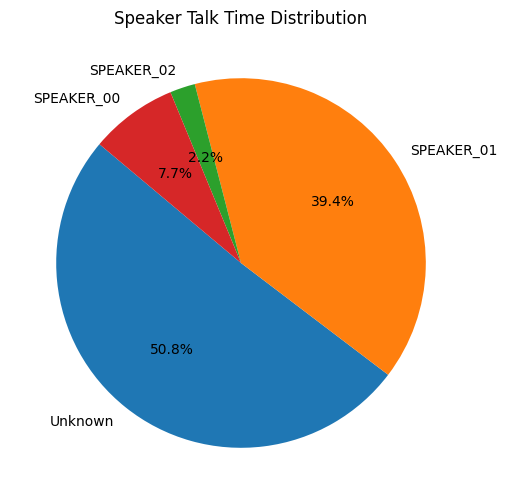

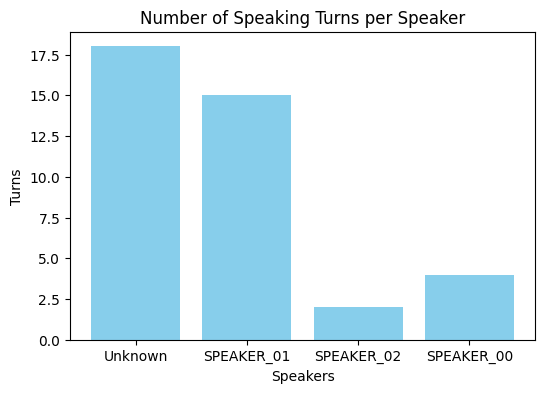

In [17]:
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# === Talk Time per Speaker ===
def plot_talk_time(speaker_transcripts):
    talk_time = defaultdict(float)
    for spk, start, end, _ in speaker_transcripts:
        talk_time[spk] += (end - start)

    labels = list(talk_time.keys())
    sizes = list(talk_time.values())

    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Speaker Talk Time Distribution")
    plt.show()

# === Number of Turns per Speaker ===
def plot_speaker_turns(speaker_transcripts):
    turns = Counter([spk for spk, _, _, _ in speaker_transcripts])
    plt.figure(figsize=(6,4))
    plt.bar(turns.keys(), turns.values(), color="skyblue")
    plt.title("Number of Speaking Turns per Speaker")
    plt.xlabel("Speakers")
    plt.ylabel("Turns")
    plt.show()



# === Run Analytics ===
print("\n=== Analytics ===")

# Talk Time
plot_talk_time(final_transcript)

# Turns
plot_speaker_turns(final_transcript)


In [ ]:
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline

# 1. Load embedder + summarizer
embedder = SentenceTransformer("all-MiniLM-L6-v2")
qa = pipeline("question-answering", model="deepset/roberta-base-squad2")

# 2. Build transcript corpus
corpus = [txt for _, _, _, txt in final_transcript if txt.strip()]
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

# 3. Query function
def query_meeting(question, top_k=3):
    q_emb = embedder.encode(question, convert_to_tensor=True)
    hits = util.semantic_search(q_emb, corpus_embeddings, top_k=top_k)[0]
    retrieved = " ".join([corpus[hit['corpus_id']] for hit in hits])

    result = qa(question=question, context=retrieved)
    return result["answer"]

while True:
    q = input("Ask a question about the meeting (or 'exit'): ")
    if q.lower() == "exit":
        break
    print("Answer:", query_meeting(q))


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

C:\Users\ASUS\miniconda3\envs\meetinganalyzer\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--deepset--roberta-base-squad2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /deepset/roberta-base-squad2/resolve/main/model.safetensors (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001E336C34370>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 9bc689f3-33fa-44d8-9086-1031506d2b98)')' thrown while requesting HEAD https://huggingface.co/deepset/roberta-base-squad2/resolve/main/model.safetensors
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /deepset/roberta-base-squad2/resolve/main/model.safetensors (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001E41998BAC0>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 701c3484-cffa-4849-a140-d3221f301e1a)')' thrown while requesting HEAD https://huggingface.co/deepset/roberta-b

model.safetensors:  59%|#####9    | 294M/496M [00:00<?, ?B/s]

Falling back to torch.float32 because loading with the original dtype failed on the target device.


tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cuda:0
